### Spectral Methods

Consider a problem of solving
\\[
\begin{align*}
-\Delta u &= f, \\
u|_\Gamma &= 0.
\end{align*}
\\]
by a spectral method, where $\Omega = [0,1]^2$ is a unit square and $\Gamma=\partial\Omega$.

In a spectral method you will be working with a representation of the solution in the form
$$
u(x,y) = \sum_{i=1}^N \sum_{j=1}^N \hat{u}_{i,j} \sin(\pi i x) \sin(\pi j y),
$$
where $\hat{u}^N$ is just an $N\times N$ array.

Knowing $u(x,y)$, it is often practically not possible to compute $\hat{u}_{i,j}$ exactly. Hence one needs to use the [Discrete Sine Transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dst.html) (DST).
The python's <tt>dst</tt> computes a one-dimensional DST, but we need a two-dimensional (2D) DST, which we compute in the following way:
    
* Compute values $u(x,y)$ for $N^2$ points inside the domain $(x,y) = (h k, h \ell)$, $1\leq k,\ell \leq N$, $h = 1/(N+1)$.

* Apply <tt>dst</tt> to each line in this array. This way you will be computing a "partial" 2D DST
$$
u(x,y) = \sum_{j=1}^N \tilde{u}_{j}(x) \sin(\pi j y),
$$

* Apply <tt>dst</tt> to each column in the resulting array. This way you will be computing a full 2D DST.
<br><br>


### Problem 1 (Spectral Methods) (80pt)

* Part (a)
    - Take $u^0(x,y) = \sin(\pi x) \sin(\pi y)$ and compute $f = -\Delta u^0$. 
    - **(8pt)** Calculate, explicitly, the coefficients $\hat{f}_{i,j}$ in 
    $$
    f(x,y) = \sum_{i=1}^N \sum_{j=1}^N \hat{f}_{i,j} \sin(\pi i x) \sin(\pi j y).
    $$
    Then, using values of $f$ at $N^2$ points, calculate the coefficients $\hat{f}^{N}_{i,j}$ by the procedure outlined above.
    (Here $\hat{f}$ is an "infinite array" that you will compute explicitly, while $\hat{f}^N$ will be an NxN array that you will compute using python.)
    Compare $\hat{f}$ and $\hat{f}^N$.
    - In this case, obviously, a solution to the problem is $u=u_0$, but let us now pretend we do not know it.
    
     - **(8pt)** Compute the coefficients $\hat{u}^N$ from $\hat{f}^N$ found in part (a).

    - **(8pt)** We will estimate the error between the two solutions in the following way. We will take $N^2$ points in our domain, of the form $(h k, h \ell)$, same as before. We will then be interested in
    $$
    {\rm err}_N = \max_{1\leq k,\ell\leq N} |u^N(h k, h \ell) - u^0(h k, h \ell)|
    $$
    which we call an error of the solution. Calculate the error of your solution for a number of values of $N$. Explain your results



### Solution

Let's find the analytical solution:

$$
f = -{\Delta}u^{0} = -{\Delta}_{xx}sin(\pi x)sin(\pi y) -{\Delta}_{yy}sin(\pi x)sin(\pi y) = 2\pi^2sin(\pi x)sin(\pi y)
$$


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dst, idst
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy as sp
import pyamg

import warnings
warnings.filterwarnings("ignore")

In [2]:
def Grid(N):

    h = 1 / (N+1) # space interval

    k = np.arange(1, N+1)
    l = np.arange(1, N+1)

    x = k*h # discret space
    y = l*h
    xv,yv = np.meshgrid(x,y)
    
    return xv, yv

N = 200
xv, yv = Grid(N)

In [3]:
def u_initial(xv,yv):
    
    return np.sin(np.pi*xv)*np.sin(np.pi*yv) 

def func(xv,yv):
    
    return 2*np.pi**2*np.sin(np.pi*xv)*np.sin(np.pi*yv) # Analytical solution of f = -Δu_0

In [4]:
# Let's compute 2D dst manually from f.
# We need to apply dst to each row in the array and dst to each column of the resulting array

u_0 = u_initial(xv,yv) 
f = func(xv,yv) 
def Solution_and_Error(f,u_0):
    # f^N_i_j, calculation using values of f at N_2 points
    f_dst = dst(dst(f, type=1, axis=1, norm="ortho"), type=1, axis=0, norm="ortho") 

    u_dst = np.zeros(f_dst.shape)
    for i in range(f_dst.shape[0]):
        for j in range(f_dst.shape[0]):
            u_dst[i][j] = f_dst[i][j]/(np.pi**2*((i+1)**2 + (j+1)**2))

    u_numerical = idst(idst(u_dst, type=1, axis=0, norm="ortho"), type=1, axis=1, norm="ortho") # u_N coefficient
    error = np.max(np.abs(u_numerical - u_0)) # error of the solution

    return u_numerical, error, f_dst

u_numerical, error, f_numerical = Solution_and_Error(f, u_0)

Let's compare $\hat{f}$ - analytical and $\hat{f}^N$ - numerical coefficients:

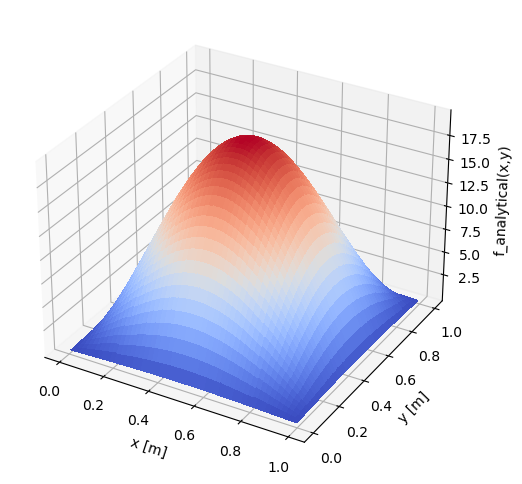

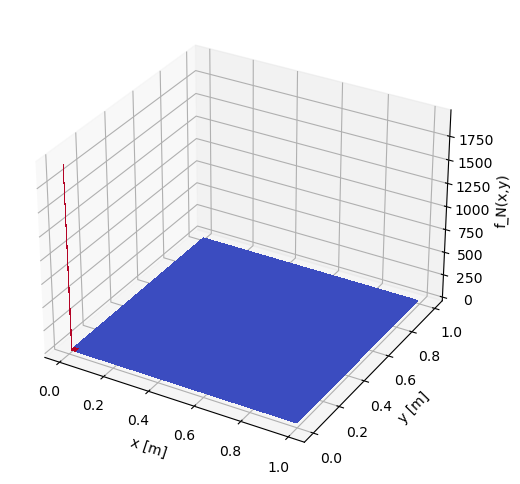

In [5]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.plot_surface(xv, yv,f,cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('f_analytical(x,y)')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.plot_surface(xv, yv,f_numerical,cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('f_N(x,y)')
plt.show()

We can see that all elements of f are zeros except [0,0]. For computed coefficient $\hat{u}^N$ from $\hat{f}^N$ matches as expected with $u^{0}$ (if we select correct norm):

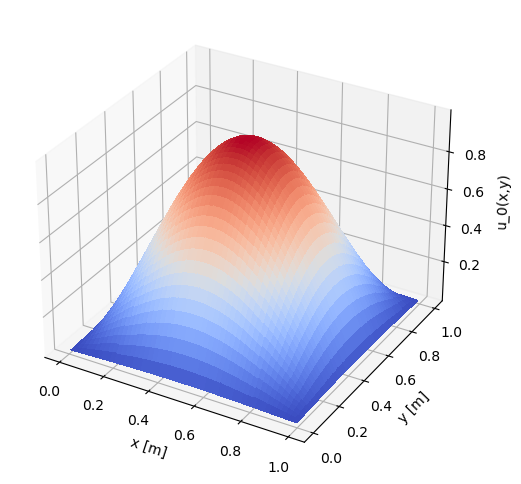

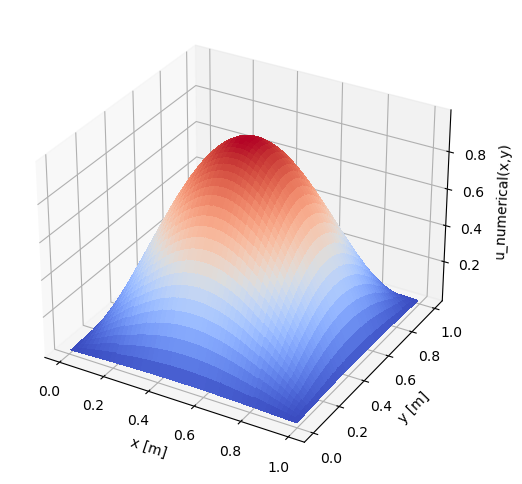

In [6]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.plot_surface(xv, yv,u_0,cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('u_0(x,y)')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.plot_surface(xv, yv,u_numerical,cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('u_numerical(x,y)')
plt.show()

Let's estimate the error between two solutions $\hat{u}^N$ and $u^{0}$:

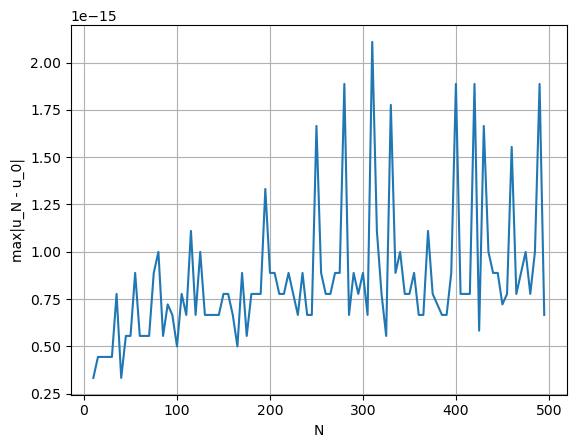

In [7]:
N_set = np.arange(10,500,5)
error_ls = []

for N in N_set:
    
    xv, yv = Grid(N)
    
    u_0 = u_initial(xv,yv) 
    f = func(xv,yv)
    
    _, error, _ = Solution_and_Error(f,u_0)
    
    error_ls.append(error)

plt.plot(N_set, error_ls)
plt.grid()
plt.xlabel('N')
plt.ylabel('max|u_N - u_0|');

It's seen that the error is always small. It's connected that desired function itself includes the basis, which happens about the expansion.


* Part (b)
    - Let us now take something a little more complicated,
    $$
    u^0(x,y) = \sin(\pi x^2) \sin(\pi y^2),
    \qquad\text{and}\qquad
    f = -\Delta u_0,
    $$
    - You cannot compute the coefficients $\hat{f}$ explicitly, so you'll have to live with only $\hat{f}^N$.
    - **(8pt)** Compute $\hat{u}^N$, the error ${\rm err}_N$, and report the error for different values of $N$. Would you say the error decays fast as $N$ increases?
    - Suppose that the spectral method has an order of convergence, in other words the error behaves like ${\rm err}_N = C N^{-\rm ord}$ and you need to find ${\rm ord}$.
        -  **(8pt)** Derive the formula
        $$
        {\rm ord}_N = \frac{\ln({\rm err}_N)-\ln({\rm err}_{2N})}{\ln(2)}
        $$
        -  **(8pt)** Hence compute ${\rm ord}_N$ for $N=1,\ldots,20$ and comment on your results. (You should start with taking each value of $N$ between 1 and 20 to understand the behavior, but you don't need to present all these numbers in your report, as long as you can illustrate the right behavior.)

In [8]:
def u_initial(xv,yv):
    
    return np.sin(np.pi*xv**2)*np.sin(np.pi*yv**2)

def func(xv,yv):
    
    return (-2*np.pi*np.cos(np.pi*xv**2) + (2*np.pi*xv)**2*np.sin(np.pi*xv**2))*np.sin(np.pi*yv**2) + (-2*np.pi*np.cos(np.pi*yv**2) + (2*np.pi*yv)**2*np.sin(np.pi*yv**2))*np.sin(np.pi*xv**2) 

In [9]:
N = 200
xv, yv = Grid(N)

u_0 = u_initial(xv,yv)
f = func(xv,yv)
u_numerical, error, _ = Solution_and_Error(f, u_0)

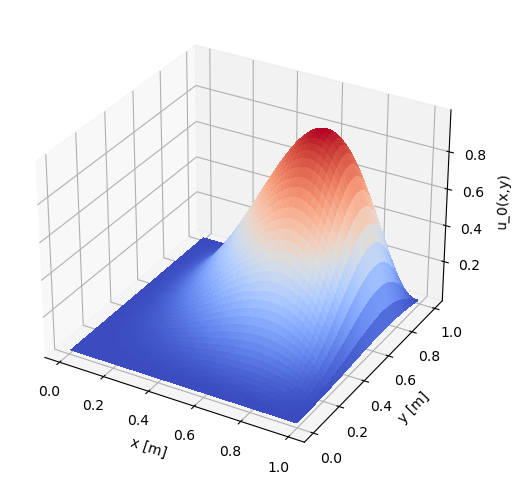

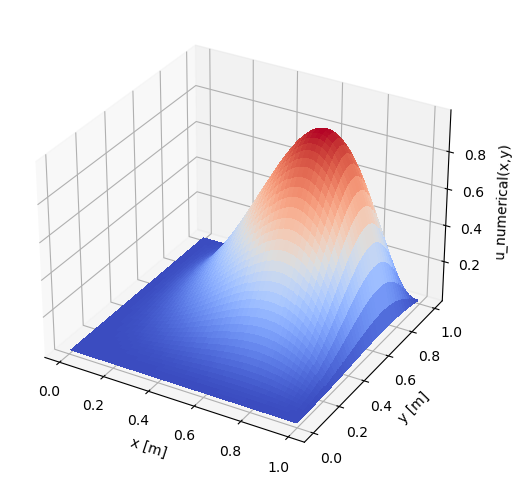

In [10]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.plot_surface(xv, yv,u_0,cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('u_0(x,y)')
plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.plot_surface(xv, yv,u_numerical,cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('u_numerical(x,y)')
plt.show()

Error for different N:

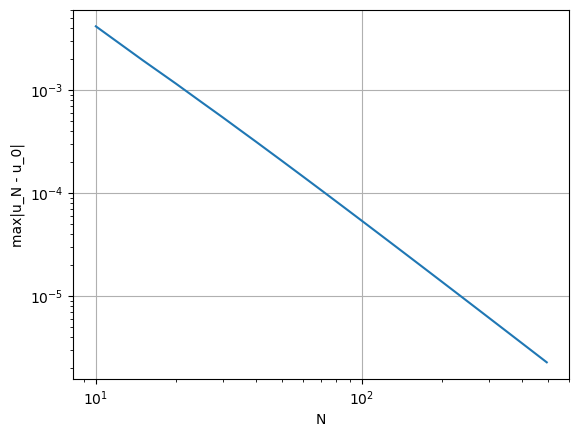

In [11]:
N_set_er = np.arange(10,500,5)
error_ls = []

for N in N_set:
    
    xv, yv = Grid(N)
    
    u_0 = u_initial(xv,yv) 
    f = func(xv,yv)
    
    _, error, _ = Solution_and_Error(f,u_0)
    
    error_ls.append(error)

plt.plot(N_set, error_ls)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('max|u_N - u_0|');

So, we can see that the error decays fast as N increases (like ${\rm err}_N = C N^{-\rm ord}$). Let's calculate order of convergence:

In [12]:
def Convergence_order(error_N, error_2N):
    
    order = (np.log(error_N) - np.log(error_2N)) / np.log(2)
    
    return order

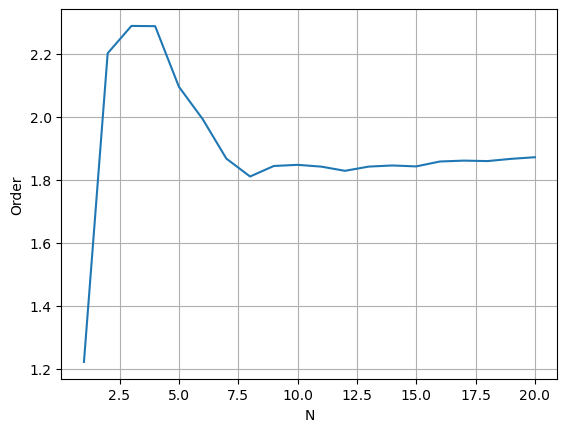

In [13]:
N_set = np.arange(1,21)
orders = []

for N in N_set:
    
    xv, yv = Grid(N)
    u_0 = u_initial(xv,yv) 
    f = func(xv,yv)
    
    _, error_N, _ = Solution_and_Error(f,u_0)
    
    
    xv, yv = Grid(2*N)
    u_0 = u_initial(xv,yv) 
    f = func(xv,yv)
    _, error_2N, _ = Solution_and_Error(f,u_0)
    
    order = Convergence_order(error_N, error_2N)
    
    orders.append(order)
    
plt.plot(N_set, orders)
plt.grid()
plt.xlabel('N')
plt.ylabel('Order');

The order of convergence is approximately ~2.

* Part (c)
    - Let us now play a "fair game": take
    $$
    f(x,y) = 1.
    $$
    We then do not know the solution.
    - Use your code from part (b) to compute $\hat{f}^N$, and $\hat{u}^N$.
    - **(8pt)** Instead of the exact error we have to use the error estimate
    $$
    {\rm errest}_N = \max_{1\leq k,\ell\leq N} |u^N(h k, h \ell) - u^{2N+1}(h k, h \ell)|
    $$
    (Why did we take $2N+1$ instead $2N$?)
    Report the values of ${\rm errest}_N$ for a sequence of values of $N$.
    
    -  **(8pt)** Hence compute ${\rm errest}_N$ for a sequence of $N$ and comment on your results.
    -  **(8pt)** Finally, using the same formula (but with ${\rm errest}$),
    $$
    {\rm ord}_N = \frac{\ln({\rm errest}_N)-\ln({\rm errest}_{2N})}{\ln(2)}
    $$
    compute ${\rm ord}_N$ for a squence of values of $N$. Comment on your results. 
*  **(8pt)** Compare the behavior for ${\rm err}$, ${\rm errest}$, and ${\rm ord}$ for parts (b) and (c). What is the main reason for the qualitative difference in the speed of convergence?

So, to compare the results in the same nodes we need to use $2N+1$ instead $2N$. Let's find the error estimate:

In [14]:
def Solution_and_Error(f):
    
    f_dst = dst(dst(f, type=1, axis=1, norm="ortho"), type=1, axis=0, norm="ortho") 
    u_dst = np.zeros(f_dst.shape)
    for i in range(f_dst.shape[0]):
        for j in range(f_dst.shape[0]):
            u_dst[i][j] = f_dst[i][j]/(np.pi**2*((i+1)**2 + (j+1)**2))
    u_numerical = idst(idst(u_dst, type=1, axis=0, norm="ortho"), type=1, axis=1, norm="ortho") # u_N coefficient

    return u_numerical, f_dst

In [15]:
N_set_er = np.arange(10,500,5)
errest_ls = []

for N in N_set_er:
    
    f = np.ones((N, N))
    u_numerical_N, _ = Solution_and_Error(f)
    
    f_ = np.ones((2*N+1, 2*N+1))
                
    u_numerical_2N, _ = Solution_and_Error(f_)
    

    errest = np.max(np.abs(u_numerical_N - u_numerical_2N[1::2,1::2]))
    errest_ls.append(errest)

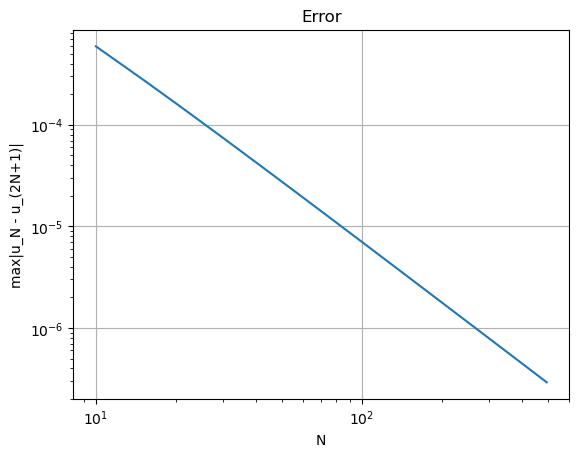

In [16]:
plt.plot(N_set_er, errest_ls)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('max|u_N - u_(2N+1)|')
plt.title("Error");

The error is close to the error for task b, but a little bit bigger. Let's find the convergence order:

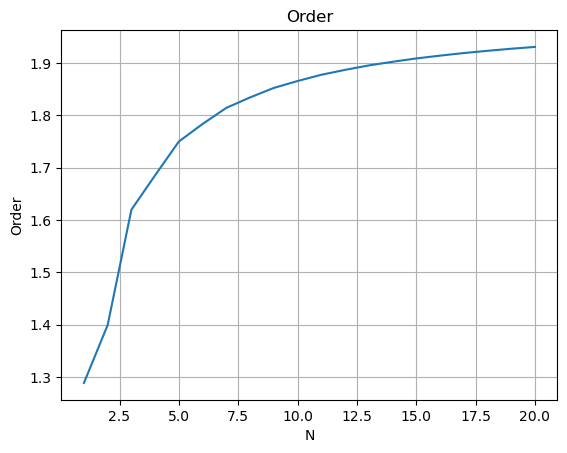

In [17]:
N_set = np.arange(1,21)
orders_errest = []

for N in N_set:
    
    f_0 = np.ones((N, N))
    u_numerical_N, _ = Solution_and_Error(f_0)
    
    f_1 = np.ones((2*N+1, 2*N+1))
    u_numerical_2N, _ = Solution_and_Error(f_1)
    
    errest_N = np.max(np.abs(u_numerical_N - u_numerical_2N[1::2,1::2]))
    
    
    f_2 = np.ones((2*N, 2*N))
    u_numerical_N_, _ = Solution_and_Error(f_2)
    
    f_3 = np.ones((4*N+1, 4*N+1))
    u_numerical_2N_, _ = Solution_and_Error(f_3)
    
    errest_2N = np.max(np.abs(u_numerical_N_ - u_numerical_2N_[1::2,1::2]))
    
    order = Convergence_order(errest_N, errest_2N)
    
    orders_errest.append(order)
    
plt.plot(N_set, orders_errest)
plt.grid()
plt.xlabel('N')
plt.ylabel('Order')
plt.title("Order");

Let's compare the error (when we know u_0), errest (when we don't know u_0) and order:

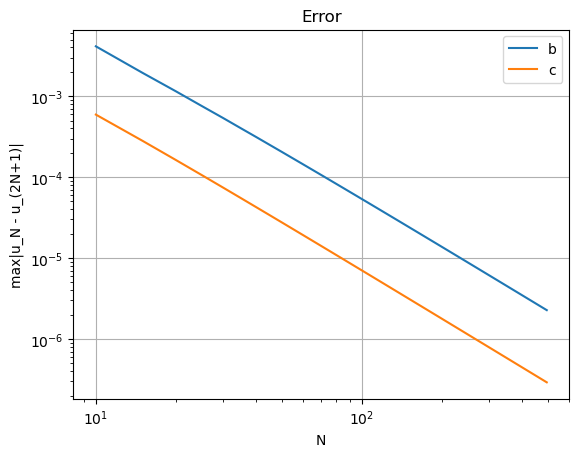

In [18]:
plt.plot(N_set_er, error_ls, label = "b")
plt.plot(N_set_er, errest_ls, label = "c")
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('max|u_N - u_(2N+1)|')
plt.title("Error")
plt.legend();

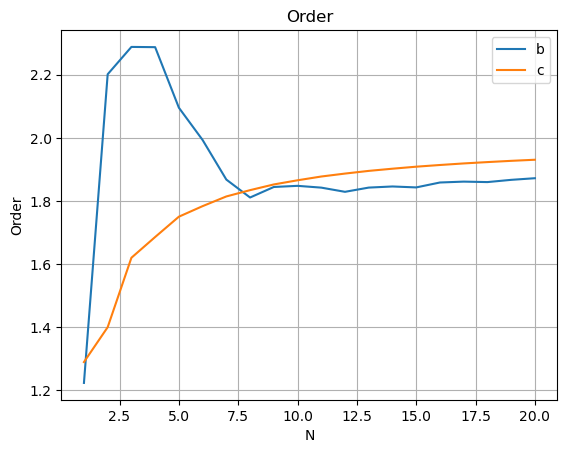

In [19]:
plt.plot(N_set, orders, label = "b")
plt.plot(N_set, orders_errest, label = "c")
plt.grid()
plt.xlabel('N')
plt.ylabel('Order')
plt.legend()
plt.title("Order");

So, as expected the error in `b` is smaller  than in `c`. But, the order is almost the same with the exception of hill for `b`. Hence, it is clear what is the main reason for the qualitative difference in the speed of convergence.

### Problem 2 (Adaptivity) (20 pts)

Complete the adaptive FEM code that solves the Poisson equations form the lecture. Use [this notebook](PS3_Pr2_code.ipynb)
The notebook implements the following, suboptimal error estimator:
$$ \begin{align*} \|\nabla (u_h-u)\|^2 &\leq~~ С \sum_T h_T^2 \|f\| _{L^2}^2 \end{align*}.$$

* (a) implement the following estimator `simple_2_estimator`:
$$ \begin{align*} \|\nabla (u_h-u)\|^2 &\leq~~ С \sum _{\gamma} h _{\gamma} \big\|[\nabla u _h] _{\gamma} \big\|_{L^2(\gamma)}^2 \end{align*}.$$

* (b) modify the function `good_estimator` and hence implement the right estimator: $$ \begin{align*} \|\nabla (u_h-u)\|^2 &\leq~~ С \sum_T h_T^2 \|f\| _{L^2}^2 + С \sum _{\gamma} h _{\gamma} \big\|[\nabla u _h] _{\gamma} \big\|_{L^2(\gamma)}^2 \end{align*}.$$ You can refer to the [notebook](https://github.com/MakaEdgar/NumModeling_Seminars/blob/main/Seminar_3_refine_mesh.ipynb) presented at the adaptivity lecture.

* (c) compare the efficiency of all the three estimators and comment which one(s) is/are best.


In [23]:
def suboptimal_estimator(neigh, edges, mp, mt, sol):
    indicator = np.zeros(len(neigh))-1
    for i in range(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]]
            n = [-e[1], e[0]]
            n = n / lin.norm(n)
            indicator[i] =  (np.dot((compute_grad(mt[int(neigh[i][0])], mp, sol) 
                        - compute_grad(mt[int(neigh[i][1])], mp, sol)), n)**2*lin.norm(e)**2)
            
    return indicator

In [24]:
def simple_edges_estimator(neigh, edges, mp, mt, sol, right_hand_side):
    indicator = np.zeros(len(neigh))-1
    for i in range(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]]
            n = [-e[1], e[0]]
            n = n / lin.norm(n)
            
            indicator[i] =  (#here the first part of the formula should be inserted
                        + 0.5*((norm_f(mp, mt[int(neigh[i][0])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][0])]))**2 
                        + norm_f(mp, mt[int(neigh[i][1])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][1])]))**2)))
                           
    return indicator

In [25]:
def good_edges_estimator(neigh, edges, mp, mt, sol, right_hand_side):
    indicator = np.zeros(len(neigh))-1
    for i in range(len(indicator)):
        if not (neigh[i] == -1).any():
            e = mp[edges[i][1]] - mp[edges[i][0]]
            n = [-e[1], e[0]]
            n = n / lin.norm(n)
            indicator[i] =  (np.dot((compute_grad(mt[int(neigh[i][0])], mp, sol) 
                        - compute_grad(mt[int(neigh[i][1])], mp, sol)), n)**2*lin.norm(e)**2
                        + 0.5*((norm_f(mp, mt[int(neigh[i][0])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][0])]))**2 
                        + norm_f(mp, mt[int(neigh[i][1])], right_hand_side)
                        *(p_triangle(mp, mt[int(neigh[i][1])]))**2)))
            
    return indicator